In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# try:
#   from rclp import rclp.LinearPool
# except:
#   !pip install git+https://github.com/reichlab/qenspy@params
#   from qenspy import qens

from rclp.rclp import LinearPool

import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

from numpy.random import default_rng
from scipy.stats import norm

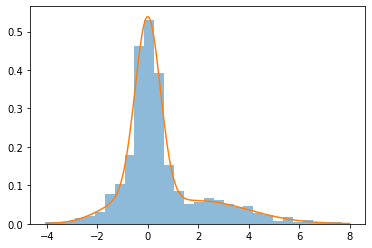

In [2]:
# simulate data from a mixture of normal distributions
# mixture parameters
w = [0.1, 0.6, 0.3]
mu = np.array([-1.0, 0.0, 2.0])
sigma = np.array([1.0, 0.5, 2.0])

# sample size
n = 1000

# init rng
rng = default_rng(42)

# mixture component indicator; there is probably a better way?
z = np.argmax(rng.multinomial(n=1, pvals=w, size=n), axis=1)

# sampled values of outcome variable
y = rng.standard_normal(n) * sigma[z] + mu[z]

# make a plot with histogram of sampled values and exact density of the mixture
y_grid = np.linspace(start=-4.0, stop=8.0, num=201)
f = w[0] * norm.pdf(y_grid, loc=mu[0], scale=sigma[0]) + \
    w[1] * norm.pdf(y_grid, loc=mu[1], scale=sigma[1]) + \
    w[2] * norm.pdf(y_grid, loc=mu[2], scale=sigma[2])
plt.hist(y, bins=30, density=True, histtype='stepfilled', alpha=0.5)
plt.plot(y_grid, f)
plt.show()

In [3]:
# fit a weighted mean ensemble to attempt to recover the mixture weights,
# assuming the component distributions are known

# first, calculate the log pdf and cdf values of each y from the component distributions
# arranged in arrays of shape (1000, 3)
log_f = np.stack([norm.logpdf(y, loc=mu[i], scale=sigma[i]) for i in range(3)], axis=1)
log_F = np.stack([norm.logcdf(y, loc=mu[i], scale=sigma[i]) for i in range(3)], axis=1)

# define a linear pool object for 3 component models and fit it
lp = LinearPool(M=3)
lp.fit(log_f = log_f, log_F = log_F, optim_method="adam", num_iter=100, learning_rate=0.1)

In [4]:
# estimated ensemble parameters
# compare to true values of [0.1, 0.6, 0.3]
lp.unpack_params(lp.get_param_estimates_vec())

{'w': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.10893007, 0.5879695 , 0.30310047], dtype=float32)>}

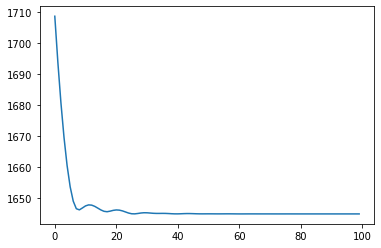

In [5]:
# plot loss trace
plt.plot(lp.loss_trace)